In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import os, sys
from tqdm import tqdm
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize


from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers import Input, Dense
from keras.layers.core import Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import Model

import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator


from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_input_Xception

# DATA Augmentation

Dans ce notebook on cherche à améliorer encore un peu le meilleur des modèles, "Xception". 
Pour cela on réalise une augmentation de données. On multiplie d'un facteur 4 la  quantité d'images initiales en appliquant simplement des transformations géométriques sur les images initiales (rotation d'angles faibles, zooms légers, translations etc...) en définissant un générateur de transformations aléatoires. 
En effet, même si ces images se ressemblent beaucoup, l'intensité de chaque pixel est transformée. Cela aide donc l'algorithme à mieux comprendre le sens des images. Nous n'avons pas utilisé ce procédés dans la méthode manuelle (utilisant des visual words) car les points clefs sont très similaires dans le cas de plusieurs images générées par ce procédés, et donc l'apport d'information est limité. Ce n'est pas le cas ici puisque le réseau de neurones apprend par lui même les caractéristiques qu'il juge pertinante. Passé un certain cap l'augmentation de données n'apporte plus d'informations, il faut alors augmenter le nombre d'images réelles pour obtenir des meilleures performances. L'augmentation d'images permet d'obtenir un score très légérement meilleur dans notre cas, on gagne entre 1 et 3% par rapport au modèle initial. Cela s'explique par le fait que le modèle est déjà très performant initialement et que certaines erreurs correspondent en fait à des maladresse d'étiquetage.

In [3]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    #print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [4]:
# compter et ouvrir les fichiers 

# Open a file
path = "./Images"
dirs = os.listdir( path )

liste_name = []
liste_number = [] 

# This would print all the files and directories
for file in dirs:
    
    liste_name.append(str(file))
    path2 = "./Images/" + str(file)
    dirs2 = os.listdir( path2 )
    
    n = 0
    for pictures in dirs2:
        n = n + 1 
    liste_number.append(n)

In [5]:
# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

train_dim = len(dirs)

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

test_dim = len(dirs)

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

valid_dim = len(dirs)
    
print (train_dim, test_dim, valid_dim)

14855 5777 5827


In [7]:
valeurs = plot_value_counts('breed',df=labels)

liste_name = valeurs.iloc[:,0]

In [8]:
print (liste_name.shape)

(120,)


In [6]:
# PARAMS 

# nombre de classes (races de chiens)
nb_classes = 120
dim_Xception = 299
dim_vgg19 = 224

DO = 4


# ouvrir le fichier 

labels = pd.read_csv('labels.csv')

In [9]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [10]:
X_trainXception = np.zeros((DO*train_dim,10,10,2048),dtype=np.float32)

y_train = np.zeros((DO*train_dim,nb_classes),dtype='uint32')

X_testXception = np.zeros((test_dim,10,10,2048),dtype=np.float32)

y_test = np.zeros((test_dim,nb_classes),dtype='uint32')

X_validXception = np.zeros((valid_dim,10,10,2048),dtype=np.float32)

y_valid = np.zeros((valid_dim,nb_classes),dtype='uint32')



In [11]:
model_xception = Xception(weights='imagenet', include_top=False)


In [12]:
# DEAL WITH DATA AUGMENTATION

j_train = 0

# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )


for file in (dirs):  
    
    
    if (j_train == 20000):
        print (1)
    if (j_train == 40000):
        print (2)
    
    if (j_train == 60000):
        print (3)
        
    
    if (j_train == 70000):
        print (3)
    
        

    #index = file.find('g') 
       
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_img = label_binarize([class_name], classes=liste_name)
    #if (j_train>0):
        #print (y_train[j_train-1,:])
        
    file_picture =  "./images_t/tr/" + str(file)
        
    img = load_img(file_picture, target_size=(299, 299))  # this is a PIL image 
    x_img = img_to_array(img)
    
    x_img = x_img.reshape((1,) + x_img.shape)    
    
    i_b = 0     
    for x_batch in train_datagen.flow(x_img):
                
        i_b += 1
        
        imput_train_xception = preprocess_input_Xception(x_batch.copy())
        train_xception = model_xception.predict(imput_train_xception) #,batch_size=32)
        
        X_trainXception[j_train,:,:,:] = train_xception[0,:,:,:]
        y_train[j_train,:] = y_img[:]      
    
        
        j_train = j_train + 1
        
        if i_b > DO - 1:
            
            break  # otherwise the generator would loop indefinitely

1
2


In [13]:
j_valid = 0

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

for file in (dirs):
    
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_valid[j_valid,:] = label_binarize([class_name], classes=liste_name)
    #print (y_valid[j_valid,:])
        
    file_picture = "./images_t/valid/" + str(file)
        
    img = load_img(file_picture, target_size=(299, 299))  # this is a PIL image
    
    x_img = img_to_array(img)
    x_img = x_img.reshape((1,) + x_img.shape) 
    
    imput_train_xception = preprocess_input_Xception(x_img.copy())
    train_xception = model_xception.predict(imput_train_xception) #,batch_size=32)        
        
    
    X_validXception[j_valid,:,:,:] = train_xception[0,:,:,:]
    
            
    j_valid = j_valid + 1

In [14]:
j_te = 0

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

for file in (dirs):
    #print (file)
            
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    #print (class_name)
    y_test[j_te,:] = label_binarize([class_name], classes=liste_name)
    #print (y_test[j_te,:])
        
    file_picture = "./images_t/te/" + str(file)
    
    img = load_img(file_picture, target_size=(299, 299))  # this is a PIL image
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
        
    
    x_img = img_to_array(img)
    x_img = x_img.reshape((1,) + x_img.shape) 
    
    imput_train_xception = preprocess_input_Xception(x_img.copy())
    train_xception = model_xception.predict(imput_train_xception) #,batch_size=32)       
    
    X_testXception[j_te,:,:,:] = train_xception[0,:,:,:] 
        
    j_te = j_te + 1

In [22]:
j_te

0

In [15]:
def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

Xception_branch, Xception_input = input_branch(input_shape=(10, 10, 2048))


net = Dropout(0.34)(Xception_branch)
net = Dense(1024, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.34)(net)
net = Dense(120, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[Xception_input], outputs=[net])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 10, 2048)      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              524288    
__________

In [16]:
# checkpoints

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_br2eed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/best{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])


model.fit([X_trainXception], y_train, 
          validation_data=([X_validXception], y_valid),
          epochs=2, batch_size=3, callbacks=[model_checkpoint], verbose=2)

Train on 59420 samples, validate on 5827 samples
Epoch 1/2
 - 156s - loss: 1.2547 - acc: 0.6877 - val_loss: 0.4149 - val_acc: 0.8974
Epoch 2/2


In [28]:
predictions = model.predict([X_testXception])
#print (predictions[0:5,:])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in y_test]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))

Test accuracy: 88.8697%


In [19]:
list_predict = []
list_test = []

for i in range (len(breed_predictions)):
    list_predict.append(np.argmax(predictions[i]))
    list_test.append(np.argmax(y_test[i,:]))
    

d = {'predict': list_predict, 'test': list_test}
df = pd.DataFrame(data=d)

valeurs = plot_value_counts('test',df=df)
print (valeurs.shape)
print (nb_classes)

valeurs['test'] = valeurs['test'].astype('float64')

valeurs = valeurs.sort_values(by=['test'])



heat_matrix = np.zeros((nb_classes,nb_classes))


for i in range (valeurs.shape[0]):
    for j in range (valeurs.shape[0]):
        
        heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])

(120, 3)
120


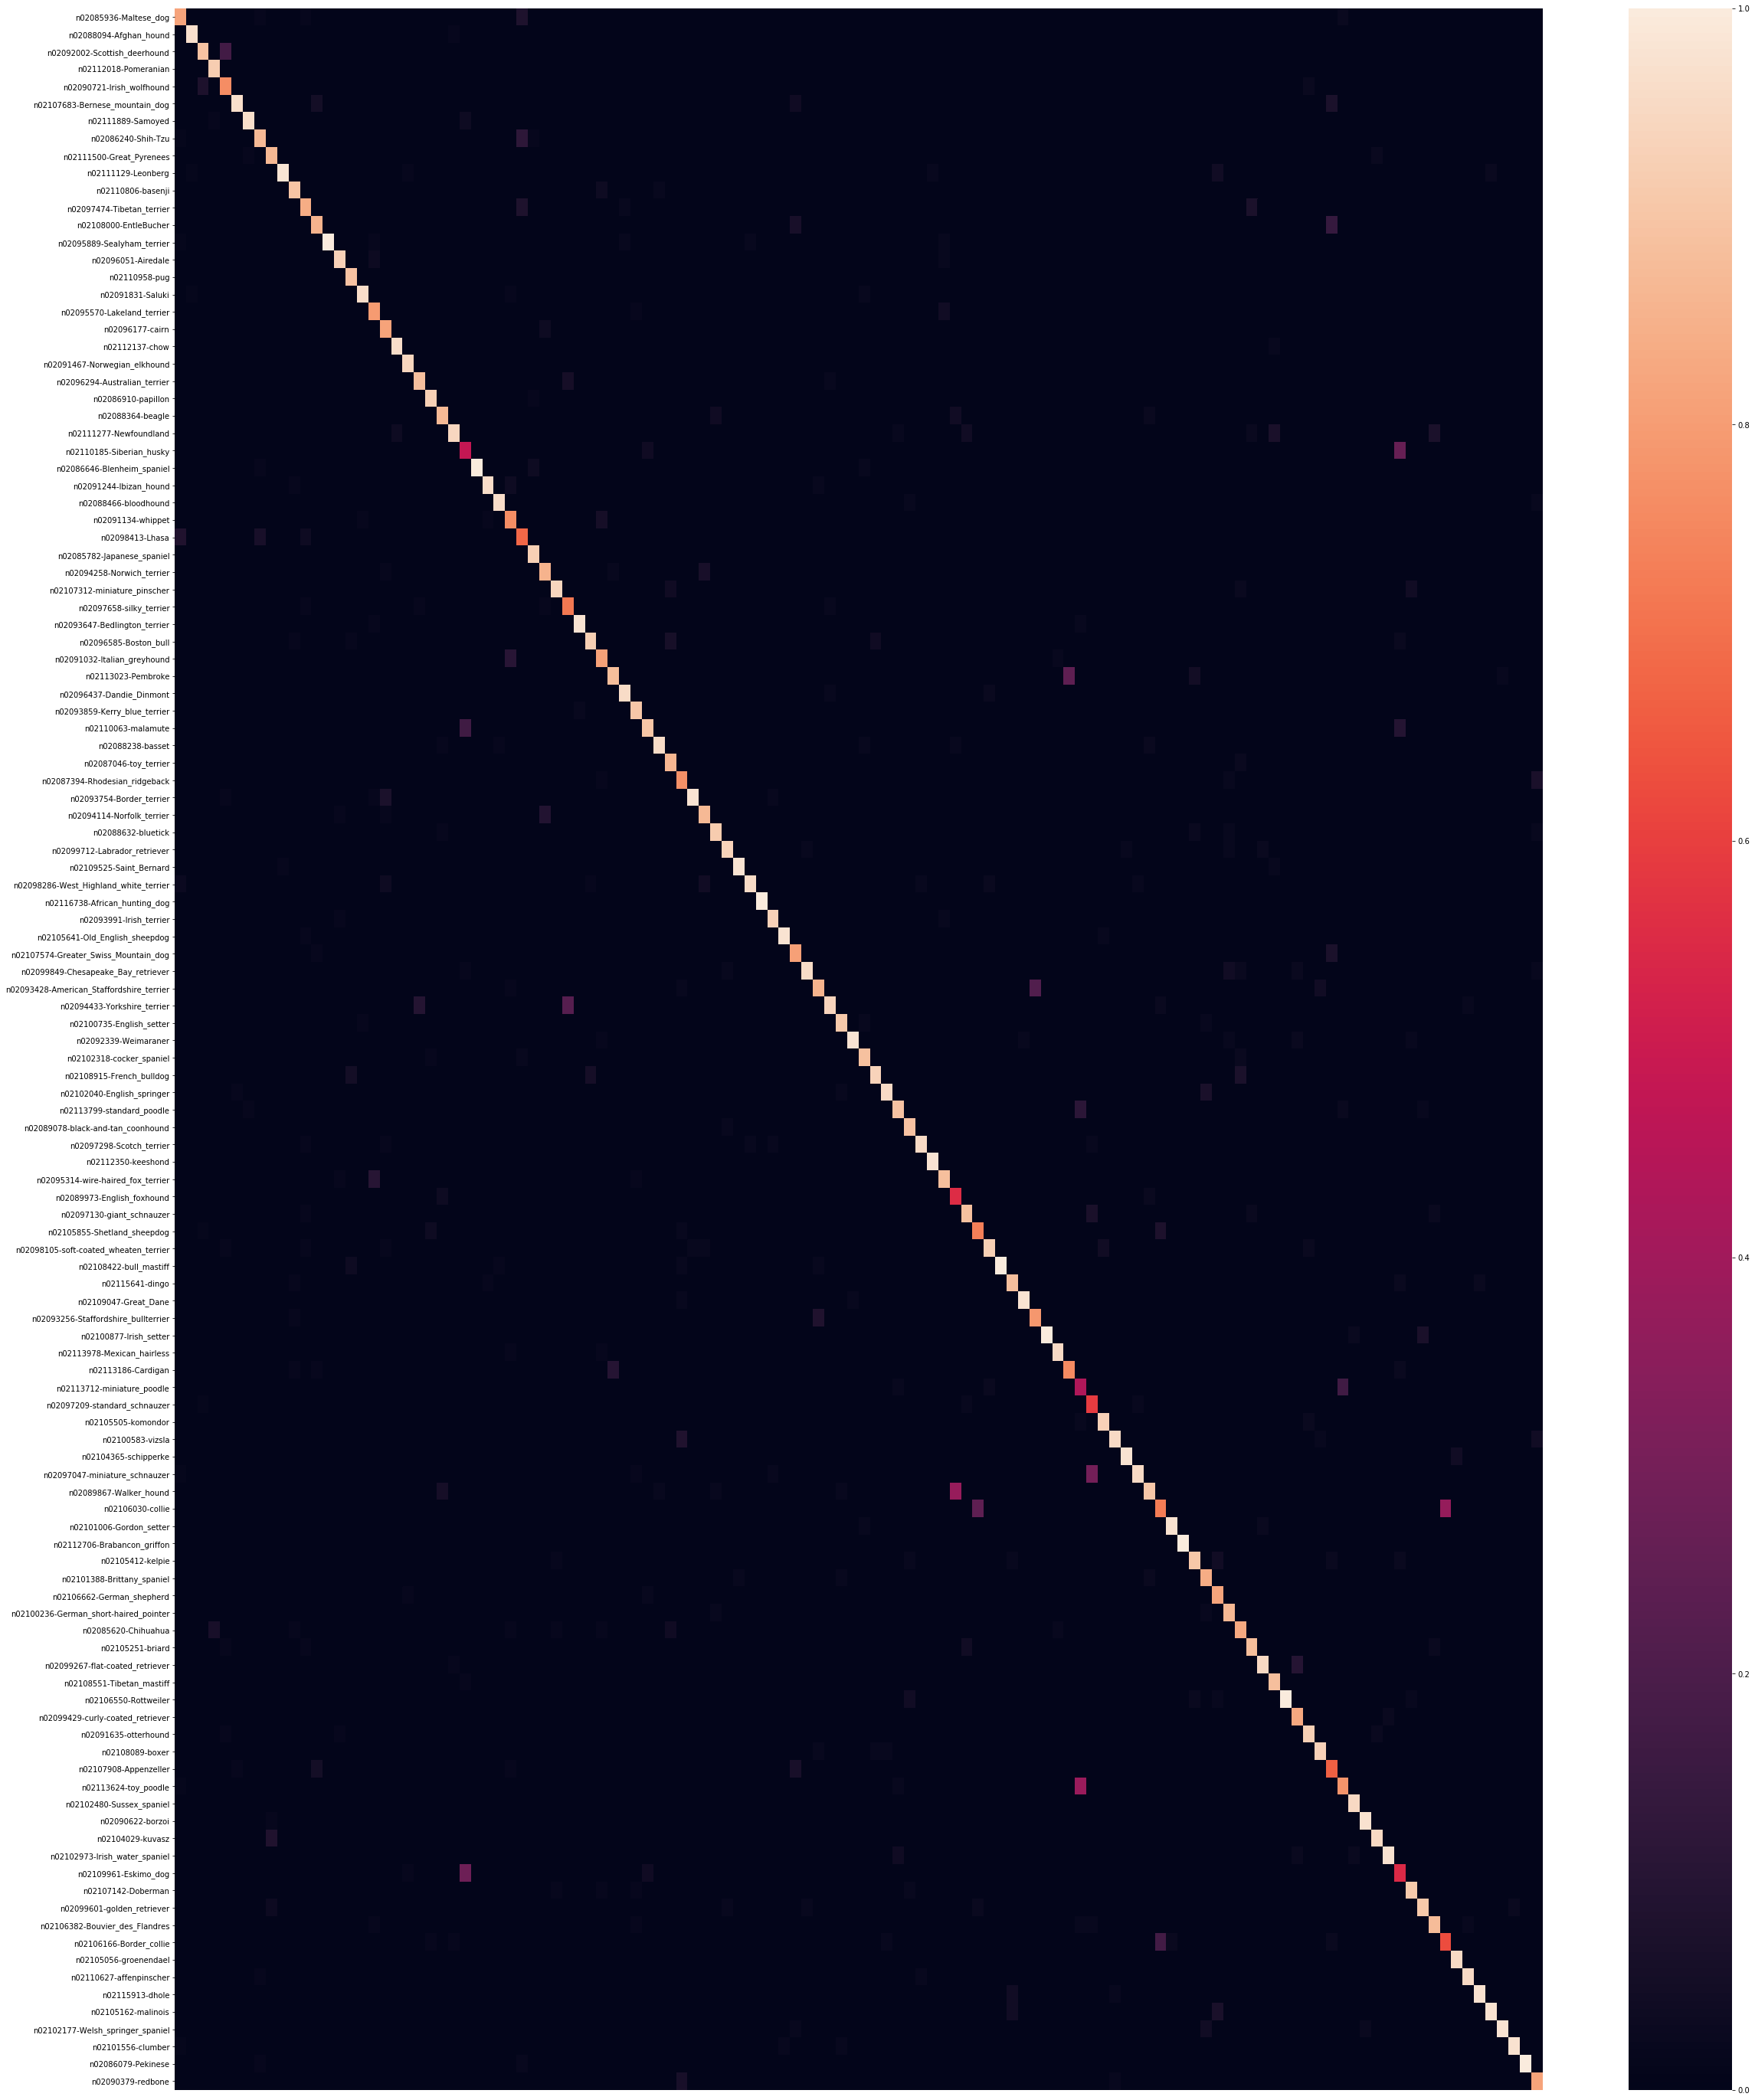

In [20]:
plt.figure(figsize=(40,50))

ax = sns.heatmap(heat_matrix,yticklabels=liste_name)

ax.axes.get_xaxis().set_visible(False)

plt.savefig('heatmap_3_do.png')

In [48]:
np.save('heatmap_mixed1_do.npy', heat_matrix)
np.save('liste_name_do.npy', np.asarray(liste_name))

In [21]:
def performance_best(liste_name,heatmap,nb):
    """retourne la liste des nb meilleures performances (race/race) ainsi que la liste des accuracies"""
    perf_name = []
    perf_element = []    
    
    for i in range (heatmap.shape[0]):
        
        perf_element.append(heatmap[i,i])
        perf_name.append(liste_name[i])
        
    d = {'name': perf_name[:], 'acc': perf_element[:]}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values(by=['acc'], ascending=[False])
    
    a = heatmap.copy()
    for i in range (heatmap.shape[0]):
        
        # on ne tient pas compte des éléments sur la diagonale
        a[i,i] = 0
        
    liste_predict, liste_test, value = [], [], []
    for i in range (nb):        
               
        z = (np.argmax(a) + 1) / a.shape[0]
        #print (z)

        if ((np.argmax(a)+1)%(a.shape[0]) == 0):

            ordd = int(z) - 1
            abss = a.shape[0] - 1

        else : 

            ordd = int(z)
            abss = (np.argmax(a)+1)%(a.shape[0]) - 1 
            
        liste_predict.append(liste_name[ordd])        
        liste_test.append(liste_name[abss])
        
        value.append(a[ordd,abss])
            
        a[ordd,abss] = 0 
        
    d = {'predict': liste_predict[:], 'test': liste_test[:], 'fp':value[:]}
    df2 = pd.DataFrame(data=d) 
    
    df2 = df2.sort_values(by=['fp'], ascending=[False])
    
    
    return (df,df2)

In [22]:
df, df2 = performance_best(liste_name=liste_name[:],heatmap=heat_matrix[:,:],nb=30)[:]

No handles with labels found to put in legend.
/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "accuracies". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


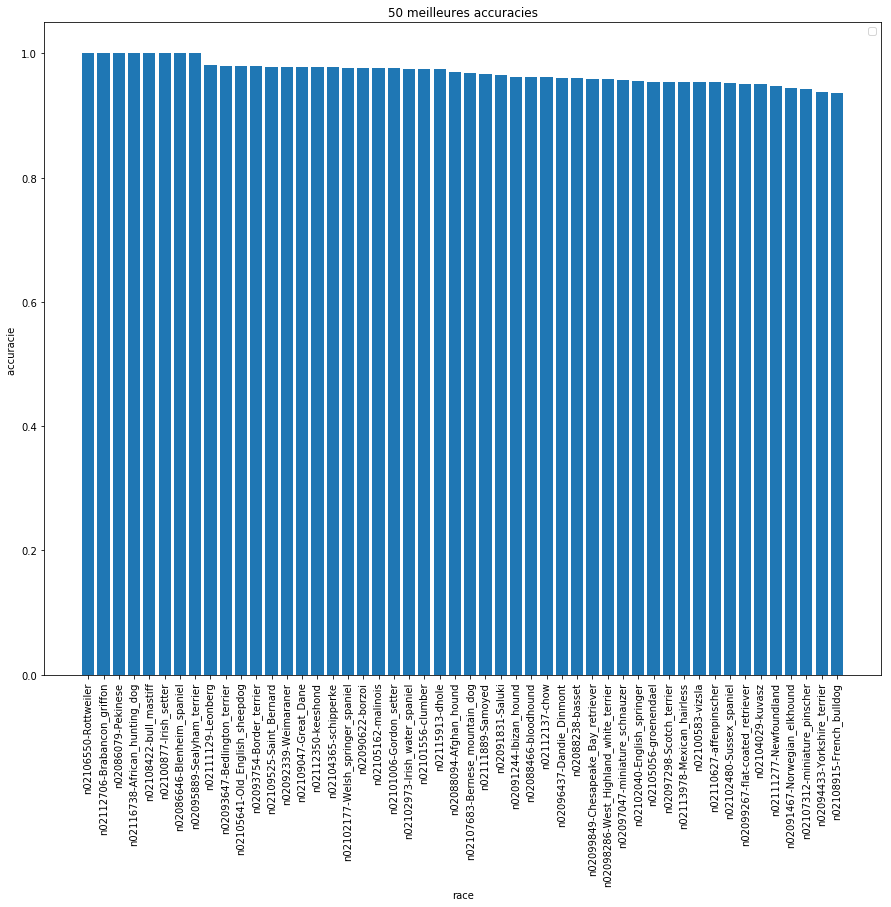

In [23]:
# afficher les performances pour les 50 races les mieux détectées

plt.figure(figsize=(15,12))
plt.title('50 meilleures accuracies')
plt.bar(df.iloc[0:50,0],df.iloc[0:50,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('best_acc.png', dpi=400)
plt.show()  

No handles with labels found to put in legend.


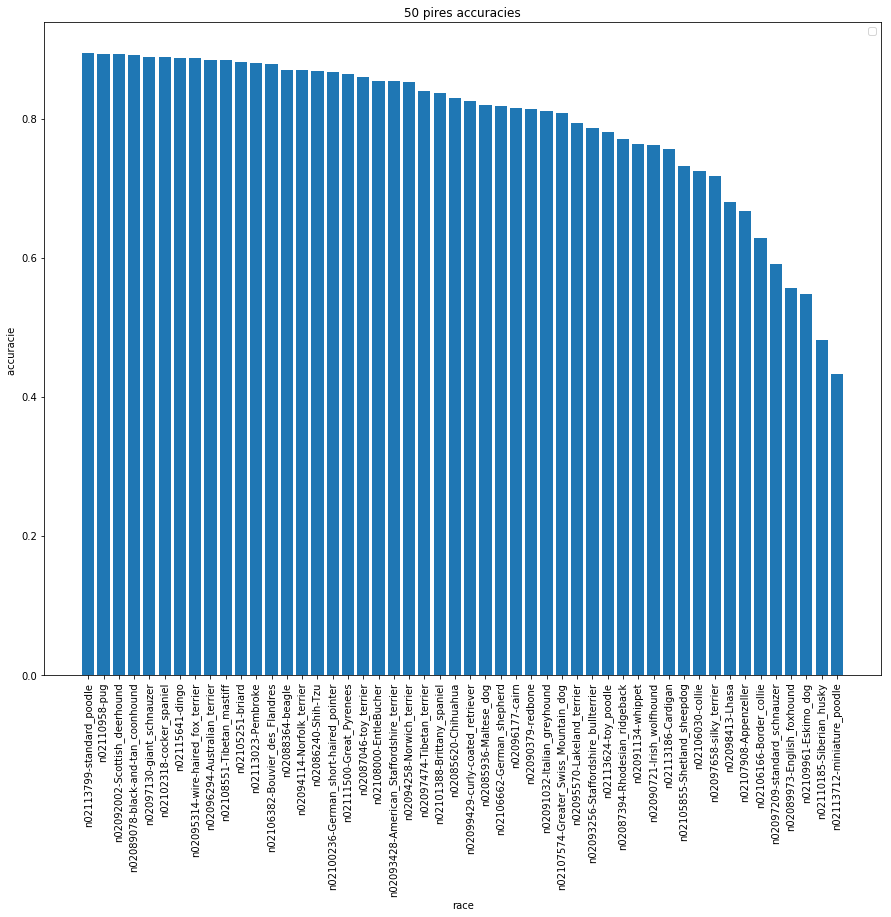

In [24]:
# afficher les 50 races les moins bien détectées

plt.figure(figsize=(15,12))
plt.title('50 pires accuracies')
plt.bar(df.iloc[70::,0],df.iloc[70::,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('worst_acc_do.png', dpi=400)
plt.show()  

In [25]:
# afficher les performance pour les 30 couples de races avec les plus d'erreur de prédiction (faux positifs)
df2

,predict,test,fp
0,n02113624-toy_poodle,n02113712-miniature_poodle,0.386364
1,n02089867-Walker_hound,n02089973-English_foxhound,0.377778
2,n02106030-collie,n02106166-Border_collie,0.372093
3,n02097047-miniature_schnauzer,n02097209-standard_schnauzer,0.295455
4,n02109961-Eskimo_dog,n02110185-Siberian_husky,0.277778
5,n02110185-Siberian_husky,n02109961-Eskimo_dog,0.261905
6,n02113023-Pembroke,n02113186-Cardigan,0.243902
7,n02106030-collie,n02105855-Shetland_sheepdog,0.243902
8,n02094433-Yorkshire_terrier,n02097658-silky_terrier,0.226415
9,n02093428-American_Staffordshire_terrier,n02093256-Staffordshire_bullterrier,0.214286
